In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [3]:
from scipy import stats

In [203]:
sns.set_context('talk')

In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [7]:
dfXtrain = pd.read_csv('preprocessed_csv/train_tree.csv', index_col='id', sep=';')
dfXtest = pd.read_csv('preprocessed_csv/test_tree.csv', index_col='id', sep=';')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_tree.csv', header=None, names=['ID', 'COTIS'], sep=';')

In [8]:
dfYtrain = dfYtrain.set_index('ID')

# Preprocessing

Заполним пропуски в департаменте

In [9]:
dfXtrain.department = dfXtrain.department.fillna(method='ffill')
dfXtrain.subreg = dfXtrain.subreg.fillna(method='ffill')

Вынесем var14, department и subreg.

In [10]:
dropped_col_names = ['var14', 'department', 'subreg'] 

def drop_cols(df):
    return df.drop(dropped_col_names, axis=1), df[dropped_col_names]

In [11]:
train, dropped_train = drop_cols(dfXtrain)
test, dropped_test = drop_cols(dfXtest)

In [12]:
dropped_train.isnull().sum()

var14         0
department    0
subreg        0
dtype: int64

Декодируем оставшиеся категориальные признаки

In [13]:
categorical = list(train.select_dtypes(exclude=[np.number]).columns)
categorical

['marque', 'energie_veh', 'profession', 'var6', 'var8']

In [14]:
list(test.select_dtypes(exclude=[np.number]).columns)

['marque', 'energie_veh', 'profession', 'var6', 'var8']

In [15]:
for col in categorical:
    print(col, train[col].nunique())

marque 154
energie_veh 5
profession 17
var6 5
var8 23


energie_veh и var6 с помощью get_dummies

In [16]:
small_cat = ['energie_veh', 'var6']

In [17]:
train = pd.get_dummies(train, columns=small_cat)
test = pd.get_dummies(test, columns=small_cat)

Для остальных посчитаем сглаженные средние таргета

In [18]:
big_cat = ['marque', 'profession', 'var8']

Описание для начала

In [19]:
df = pd.concat([dfYtrain.describe()] + [train[col].value_counts().describe() for col in big_cat], axis=1)
df

,COTIS,marque,profession,var8
count,300000.000000,154.000000,17.000000,23.000000
mean,346.063566,1946.168831,17647.058824,13018.000000
std,119.870510,8040.202889,29867.244501,24502.085807
min,94.780000,1.000000,393.000000,1.000000
25%,262.050000,3.000000,2610.000000,775.000000
50%,323.220000,11.500000,5829.000000,2208.000000
75%,407.500000,359.750000,13273.000000,7045.000000
max,1518.810000,73371.000000,110354.000000,91826.000000


Сглаживать будем с 500

Будем использовать среднее, 25%, 50% и 75%

Декодирование

In [20]:
class EncodeWithAggregates():

    def __init__(self, cols, y_train, train, *tests, smooth_coef=None):
        self.cols = cols
        self.y_train = y_train
        self.train = train
        self.tests = tests
        self.Xs = (self.train,) + self.tests
        
        self.miss_val = 'NAN'
        self.percentiles = [25, 50, 75]
        self.names = ['Mean'] + [str(q) for q in self.percentiles]
        self.aggs = [np.mean] + [self.percentile_fix(q) for q in self.percentiles]
        self.miss_val_fills = [agg(y_train) for agg in self.aggs]
        self.train_aggs = [agg(y_train) for agg in self.aggs]
        if smooth_coef:
            self.smooth_coef = smooth_coef
        else:
            self.smooth_coef = {col: 0 for col in cols}
        

    def percentile_fix(self, q):
        def wrapped(a):
            return np.percentile(a, q)

        return wrapped
        
    
    def transform(self):
        for col in self.cols:
            self.encode(col)
            gc.collect()
        return self.Xs
    
    
    def encode(self, col):
        df = pd.concat([self.y_train, self.train[col]], axis=1)
        dfgb = df.groupby(col)
        dfsize = dfgb.size()
        dfsize.ix[self.miss_val] = 0

        for X in self.Xs:                
            agg_size = dfsize.ix[X[col].fillna(self.miss_val)]
            agg_size = pd.DataFrame({'size': agg_size}).set_index(X.index)['size']
            agg_name = "{}_{}".format(col, 'size')
            X[agg_name] = agg_size

        for name, agg, miss_val_fill, train_agg in zip(self.names, self.aggs, self.miss_val_fills, self.train_aggs):
            dfm = dfgb.agg(agg)
            dfm.ix[self.miss_val] = miss_val_fill
            for X in self.Xs:                
                agg_df = dfm.ix[X[col].fillna(self.miss_val)].set_index(X.index)[self.y_train.name]
                agg_size = dfsize.ix[X[col].fillna(self.miss_val)]
                agg_size = pd.DataFrame({'size': agg_size}).set_index(X.index)['size']
                agg_name = "{}_{}".format(col, name)
                X[agg_name] = (agg_df * agg_size + self.smooth_coef[col] * train_agg) / (self.smooth_coef[col] + agg_size)
        
        self.Xs = [X.drop(col, axis=1) for X in self.Xs]

In [21]:
smooth_coef = {'profession': 0, 'var8': 500, 'marque': 500}

train, test = EncodeWithAggregates(big_cat, dfYtrain['COTIS'], train, test, smooth_coef=smooth_coef).transform()

In [22]:
test.shape

(30000, 51)

In [23]:
train.shape

(300000, 51)

In [24]:
train.fillna(-9999, inplace=True)
test.fillna(-9999, inplace=True)

In [25]:
y_train = np.array(dfYtrain)
x_train = np.array(train)
x_test = np.array(test)

In [26]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(train.crm, dfYtrain.COTIS)

In [27]:
slope, intercept, rvalue, pvalue, stderr

(3.4019808086311301,
 95.841221149398137,
 0.67260296056871227,
 0.0,
 0.0068335709763392965)

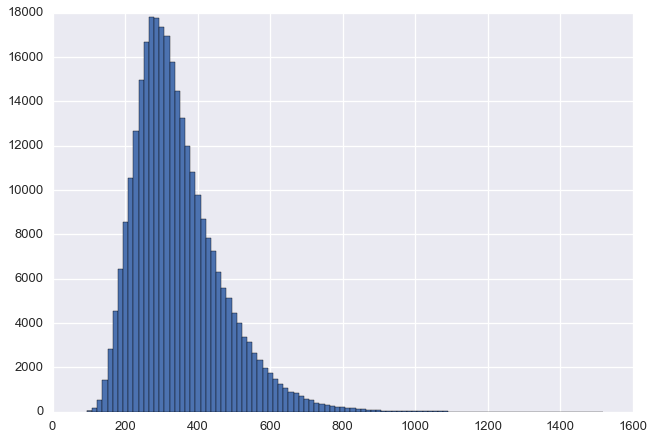

In [28]:
dfYtrain.COTIS.hist(bins=100)

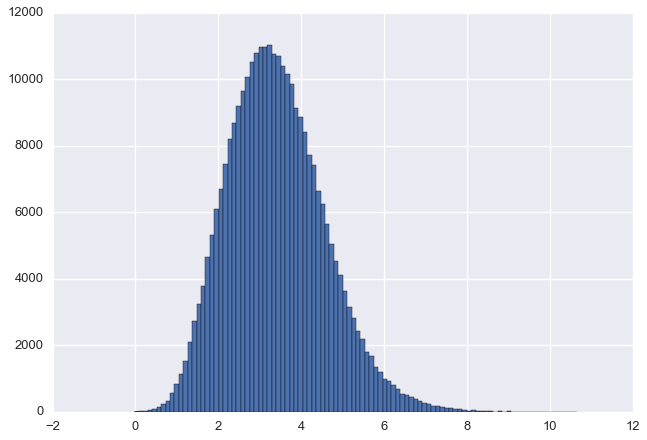

In [29]:
((dfYtrain.COTIS - intercept) / train.crm).hist(bins=100)

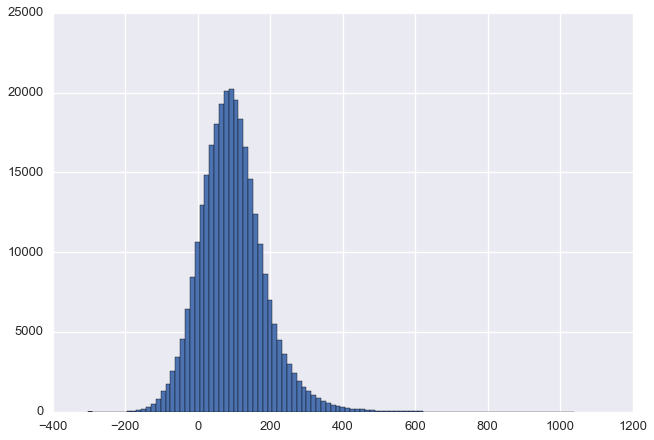

In [30]:
(dfYtrain.COTIS - slope * train.crm).hist(bins=100)

In [31]:
train.shape

(300000, 51)

In [32]:
train.drop('crm', axis=1).drop_duplicates().shape

(299971, 50)

In [33]:
train[train.drop('crm', axis=1).duplicated(keep=False)]

,annee_naissance,annee_permis,puis_fiscale,anc_veh,kmage_annuel,crm,var1,var2,var3,var4,var5,var7,var9,var10,var11,var12,var13,var15,var16,var17,var18,var19,var20,var21,var22,permis_age,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,var6_A,var6_B,var6_C,var6_D,var6_N,marque_size,marque_Mean,marque_25,marque_50,marque_75,profession_size,profession_Mean,profession_25,profession_50,profession_75,var8_size,var8_Mean,var8_25,var8_50,var8_75
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20807,1988.0,2007.0,5,1,2837,112,9.0,5,372,0,1,1.0,60,162,1,805,3,3,1.0,1,27,0,0,1,1,19.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,110354,360.052820,272.2800,330.370,424.3775,66389,358.238655,264.680191,335.825067,428.769809
20808,1988.0,2007.0,5,1,2837,106,9.0,5,372,0,1,1.0,60,162,1,805,3,3,1.0,1,27,0,0,1,1,19.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,110354,360.052820,272.2800,330.370,424.3775,66389,358.238655,264.680191,335.825067,428.769809
72227,1989.0,2008.0,7,2,7056,62,8.0,1,372,0,2,10.0,115,187,2,1245,5,0,1.0,2,24,0,0,1,5,19.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,110354,360.052820,272.2800,330.370,424.3775,91826,363.817658,274.902517,341.808783,430.492305
72228,1989.0,2008.0,7,2,7056,58,8.0,1,372,0,2,10.0,115,187,2,1245,5,0,1.0,2,24,0,0,1,5,19.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,110354,360.052820,272.2800,330.370,424.3775,91826,363.817658,274.902517,341.808783,430.492305
73260,1993.0,2012.0,5,2,2683,50,4.0,3,372,0,1,4.0,51,150,2,720,3,0,1.0,2,24,3,0,1,0,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,1137,325.568734,244.0800,313.770,390.4400,23369,296.880304,221.429119,280.141698,350.352716
73261,1993.0,2012.0,5,2,2683,50,4.0,3,372,0,1,4.0,51,150,2,720,3,0,1.0,2,24,3,0,1,0,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,1137,325.568734,244.0800,313.770,390.4400,23369,296.880304,221.429119,280.141698,350.352716
79179,1989.0,2008.0,6,17,7443,85,8.0,3,272,0,2,1.0,110,200,17,1385,5,3,1.0,1,22,0,0,1,2,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,73371,336.598258,253.334394,314.509360,398.650308,15624,333.513677,253.1075,313.480,390.2275,54018,349.780423,269.352408,326.464964,408.151470
79180,1989.0,2008.0,6,17,7443,90,8.0,3,272,0,2,1.0,110,200,17,1385,5,3,1.0,1,22,0,0,1,2,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,73371,336.598258,253.334394,314.509360,398.650308,15624,333.513677,253.1075,313.480,390.2275,54018,349.780423,269.352408,326.464964,408.151470
90599,1983.0,2002.0,7,1,7149,63,14.0,5,372,0,1,10.0,90,170,1,1278,5,1,1.0,2,37,2,0,1,0,19.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,73371,336.598258,253.334394,314.509360,398.650308,110354,360.052820,272.2800,330.370,424.3775,91826,363.817658,274.902517,341.808783,430.492305


In [34]:
first = (train[train.drop('crm', axis=1).duplicated(keep='last')]).index
second = (train[train.drop('crm', axis=1).duplicated(keep='first')]).index
slopes = (np.array(dfYtrain.COTIS[second]) - np.array(dfYtrain.COTIS[first])) / \
            (np.array(train.crm[second]) - np.array(train.crm[first]))
intercepts = np.array(dfYtrain.COTIS[first]) - slopes * np.array(train.crm[first])

In [35]:
slopes[~np.isnan(slopes)]

array([ 3.83833333,  5.41      ,  3.68      ,  4.125     ,  4.55      ,
        4.66333333,  2.13      ,  5.01      ,  4.725     ,  3.59      ,
        4.2975    ,  2.89      ,  4.665     ,  4.43277778,  2.528     ,
        4.503     ])

In [36]:
intercepts[~np.isnan(intercepts)]

array([  57.49666667,   59.73      ,   21.11      ,   52.605     ,
        111.92      ,   37.89666667,   69.67      ,   79.71      ,
         74.39      ,   43.59      ,   72.55      ,   90.76      ,
         36.45      ,   52.62222222,  109.81      ,   46.06      ])

In [37]:
slopes[~np.isnan(slopes)] - slope

array([ 0.43635252,  2.00801919,  0.27801919,  0.72301919,  1.14801919,
        1.26135252, -1.27198081,  1.60801919,  1.32301919,  0.18801919,
        0.89551919, -0.51198081,  1.26301919,  1.03079697, -0.87398081,
        1.10101919])

In [38]:
intercepts[~np.isnan(intercepts)] - intercept

array([-38.34455448, -36.11122115, -74.73122115, -43.23622115,
        16.07877885, -57.94455448, -26.17122115, -16.13122115,
       -21.45122115, -52.25122115, -23.29122115,  -5.08122115,
       -59.39122115, -43.21899893,  13.96877885, -49.78122115])

Завышение среднего intercept можно отыграть добавкой к наклону.

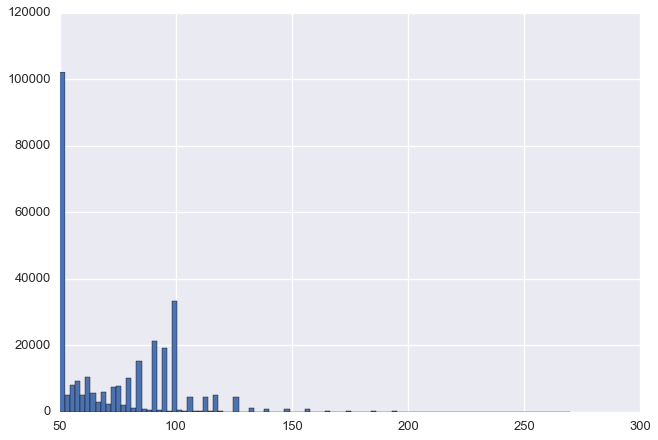

In [39]:
train.crm.hist(bins=100)

In [40]:
train.crm.value_counts().head()

50     95427
100    33270
90     20738
95     18909
85     14623
Name: crm, dtype: int64

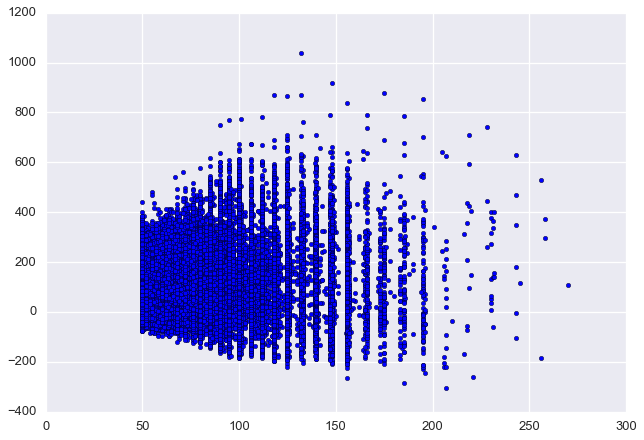

In [41]:
plt.scatter(train.crm, (dfYtrain.COTIS - slope * train.crm))

In [42]:
slopes = slopes[~np.isnan(slopes)]
intercepts = intercepts[~np.isnan(intercepts)]

In [43]:
slopes.mean(), intercepts.mean()

(4.0648715277777754, 63.523159722222424)

In [44]:
slope, intercept

(3.4019808086311301, 95.841221149398137)

(array([ 1.,  1.,  1.,  0.,  2.,  1.,  2.,  6.,  1.,  1.]),
 array([ 2.13 ,  2.458,  2.786,  3.114,  3.442,  3.77 ,  4.098,  4.426,
         4.754,  5.082,  5.41 ]),
 <a list of 10 Patch objects>)

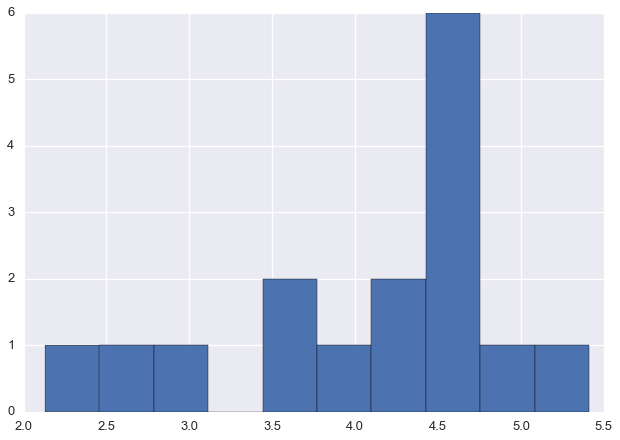

In [45]:
plt.hist(slopes)

(array([ 1.,  2.,  2.,  2.,  2.,  3.,  1.,  1.,  0.,  2.]),
 array([  21.11 ,   30.191,   39.272,   48.353,   57.434,   66.515,
          75.596,   84.677,   93.758,  102.839,  111.92 ]),
 <a list of 10 Patch objects>)

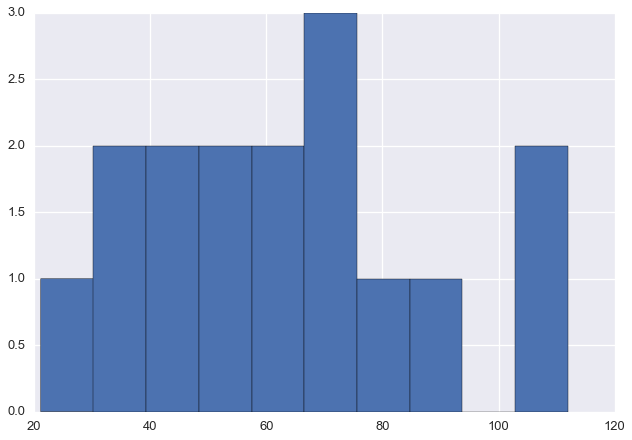

In [46]:
plt.hist(intercepts)

In [47]:
def new_diff(zero_apprx):
    return np.minimum((zero_apprx - 100) * 0.44 / train.crm, 3) + \
           np.minimum((zero_apprx - 20) * 0.44 / train.crm, 3)

In [48]:
def squeeze(apprx, number):
    for i in range(number):
        diff = new_diff(apprx)
        apprx = apprx - diff * train.crm
    return apprx


In [49]:
slope = 3.4019808086311301 #средний по всем
slope = 4.0648715277777754 #средний по дублям
slope = 3.8

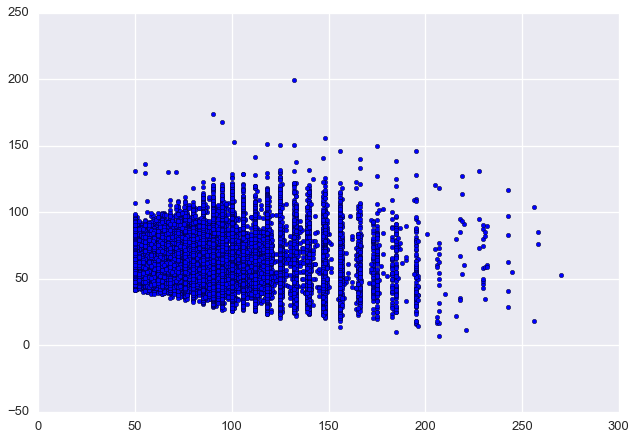

In [157]:
zero_apprx = (dfYtrain.COTIS - slope * train.crm)
inters = squeeze(zero_apprx, 1)
#inters = zero_apprx
plt.scatter(train.crm, inters)

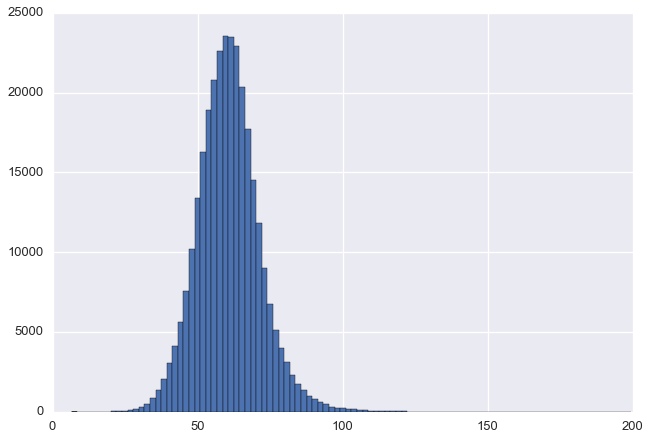

In [158]:
plt.hist(inters, bins=100)
plt.show()

In [51]:
zero_apprx = (dfYtrain.COTIS - slope * train.crm)
diff = new_diff(zero_apprx)

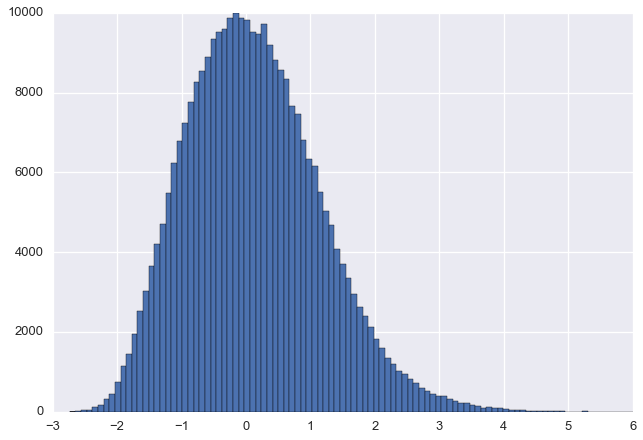

In [52]:
plt.hist(diff, bins=100)
plt.show()

Теперь у нас есть нулевое приближение для diff

# Save routines

In [53]:
dfYtest = pd.DataFrame({'ID': dfXtest.index, 'COTIS': np.zeros(test.shape[0])})
dfYtest = dfYtest[['ID', 'COTIS']]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [54]:
def save_to_file(y, file_name):
    dfYtest['COTIS'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

In [55]:
model_name = 'lin_crm'
dfYtest_stacking = pd.DataFrame({'ID': dfXtrain.index, model_name: np.zeros(train.shape[0])})
dfYtest_stacking = dfYtest_stacking[['ID', model_name]]
dfYtest_stacking.head()

,ID,lin_crm
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [56]:
def save_to_file_stacking(y, file_name):
    dfYtest_stacking[model_name] = y
    dfYtest_stacking.to_csv('stacking/{}'.format(file_name), index=False, sep=';')

# Train

In [57]:
import xgboost as xgb
XGBR = xgb.XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import LabelKFold
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

In [58]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(10, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [59]:
def mape(y_true, y_pred):
    y_pred = y_pred.reshape(y_true.shape)
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
def mape_scorer(est, X, y):
    gc.collect()
    return mape(y, est.predict(X))

In [61]:
class MyGS():
    class Element():
        def __init__(self):
            self.cv_validation_scores = []
        
        
        def add(self, score):
            self.cv_validation_scores.append(score)
    
    
    def __init__(self, param_grid, name, n_folds):
        self.param_grid = {name: param_grid}
        self.grid_scores_ = [MyGS.Element() for item in param_grid]
        
    
    def add(self, score, param_num):
        self.grid_scores_[param_num].add(score)
        

In [62]:
def get_score_list(X, y, clf, scorer):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        proba = tree.predict(X)
        predictions.append(proba)
        rf_prediction = np.mean(predictions, axis=0)
        score.append(scorer(y, rf_prediction))
    return score

In [63]:
def restore_target(diff, inters, crm, slope):
    return (diff + slope) * crm + inters

In [64]:
mape(y_train[:, 0], 60 + train.crm * (slope + diff))

-2.4779370292308642

In [65]:
intercept = 60

Сегодня мы будем обучать ExtraTrees

Разобьём на трейн и валидацию

In [66]:
validation_index = (dropped_train.department == 1) | (dropped_train.department > 90)
train_index = ~validation_index

In [89]:
subtrain, validation = train[train_index], train[validation_index]
x_subtrain = np.array(subtrain)
x_validation = np.array(validation)

ysubtrain, yvalidation = dfYtrain[train_index], dfYtrain[validation_index]
y_subtrain = np.array(ysubtrain).flatten()
y_validation = np.array(yvalidation).flatten()

In [90]:
diffsubtrain, diffvalidation = diff[train_index], diff[validation_index]
diff_subtrain = np.array(diffsubtrain)
diff_validation = np.array(diffvalidation)

In [91]:
diff_validation.shape

(34889,)

Сначала просто ExtraTree для diff

In [92]:
%%time
est = ExtraTreesRegressor(n_estimators=10, max_features=51, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(X=x_subtrain, y=diff_subtrain)

CPU times: user 1min 14s, sys: 232 ms, total: 1min 14s
Wall time: 21.9 s


In [93]:
diff_pred = est.predict(x_validation)
y_pred = restore_target(diff_pred, intercept, np.array(validation.crm), slope)
mape(y_validation, y_pred)

-9.9076416476335769

In [94]:
mape(y_validation, restore_target(diff_validation, intercept, np.array(validation.crm), slope))

-2.4535180888420265

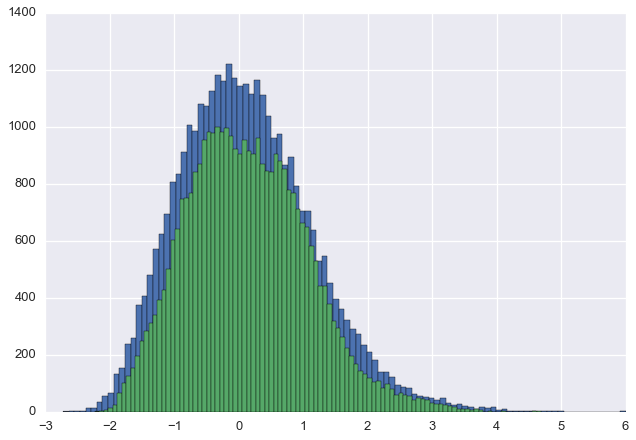

In [95]:
plt.hist(diff_validation, bins=100)
plt.hist(diff_pred, bins=100)
plt.show()

Теперь поделим subtrain на две части. На одной опять обучим diff, на другой обучим inters по ответам diff

In [96]:
est = None
gc.collect()

31156

In [109]:
%%time
sub_index = x_subtrain.shape[0] // 2
diff_est = ExtraTreesRegressor(
                n_estimators=20, max_features=51, 
                max_depth=None, n_jobs=-1, random_state=42).fit(
                        X=x_subtrain[:sub_index], y=diff_subtrain[:sub_index])

CPU times: user 1min 9s, sys: 148 ms, total: 1min 9s
Wall time: 17.7 s


In [110]:
diff_sub = diff_est.predict(x_subtrain[sub_index:])
inters_sub = y_subtrain[sub_index:] - restore_target(diff_sub, 0, np.array(subtrain.crm)[sub_index:], slope)

In [115]:
%%time
inters_est = ExtraTreesRegressor(
                n_estimators=20, max_features=51, 
                max_depth=None, n_jobs=-1, random_state=42).fit(
                        X=x_subtrain[sub_index:], y=inters_sub)

CPU times: user 1min 17s, sys: 192 ms, total: 1min 17s
Wall time: 19.8 s


In [116]:
diff_pred = diff_est.predict(x_validation)
inters_pred = inters_est.predict(x_validation)
y_pred = restore_target(diff_pred, inters_pred, np.array(validation.crm), slope)
mape(y_validation, y_pred)

-9.6758453547870928

Теперь посмотрим, будет ли сходимость, если на вывод inters_est скорректировать diff, а затем провернуть новый круг обучения 

In [125]:
from sklearn.utils import shuffle

In [152]:
%%time
sub_index = int(x_subtrain.shape[0] * 1)
num_iter = 5
diff_big_sub = diff_subtrain.copy()
inters_big_sub = np.zeros(diff_big_sub.shape) + intercept
scores = []

for iteration in tnrange(num_iter):
    x_sub, diff_sub = shuffle(x_subtrain, diff_big_sub, 
                              n_samples=sub_index, random_state=iteration * 4)
    diff_est = ExtraTreesRegressor(
                n_estimators=30, max_features=51, 
                max_depth=None, n_jobs=-1, random_state=iteration * 4 + 1).fit(
                        X=x_sub, y=diff_sub)
    diff_big_sub = diff_est.predict(x_subtrain)
    
    inters_big_sub = y_subtrain - (slope + diff_big_sub) * np.array(subtrain.crm)
    x_sub, inters_sub = shuffle(x_subtrain, inters_big_sub, 
                                n_samples=sub_index, random_state=iteration * 4 + 2)
    inters_est = ExtraTreesRegressor(
                  n_estimators=30, max_features=51, 
                  max_depth=None, n_jobs=-1, random_state=iteration * 4 + 3).fit(
                          X=x_sub, y=inters_sub)
    inters_big_sub = inters_est.predict(x_subtrain)
    diff_big_sub = (y_subtrain - inters_big_sub) / np.array(subtrain.crm) - slope
    gc.collect()
    
    diff_pred = diff_est.predict(x_validation)
    inters_pred = inters_est.predict(x_validation)
    y_pred = restore_target(diff_pred, inters_pred, np.array(validation.crm), slope)
    scores.append(mape(y_validation, y_pred))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



CPU times: user 41min 34s, sys: 9.23 s, total: 41min 43s
Wall time: 11min 5s


1, n_est_diff = 30, n_est_inters = 30

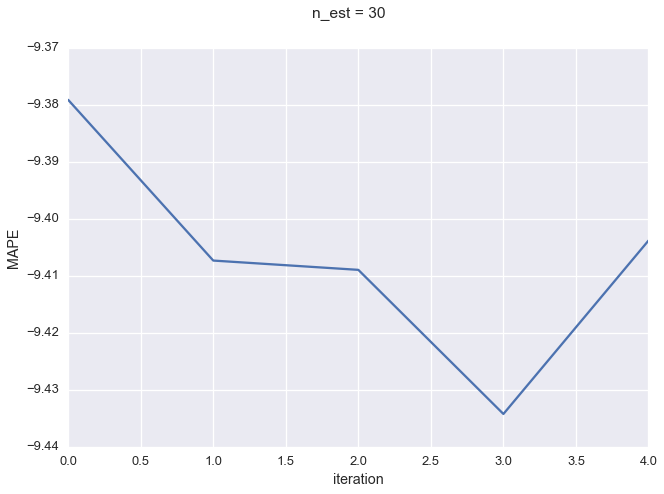

In [153]:
fig = plt.figure()
plt.plot(scores)
fig.suptitle("n_est = 30")
plt.xlabel('iteration')
plt.ylabel('MAPE')
plt.show()

1, n_est_diff = 10, n_est_inters = 10

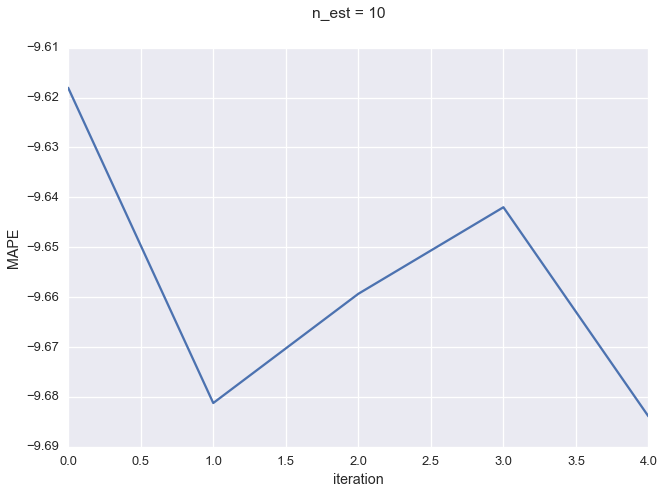

In [151]:
fig = plt.figure()
plt.plot(scores)
fig.suptitle("n_est = 10")
plt.xlabel('iteration')
plt.ylabel('MAPE')
plt.show()

1, n_est_diff = 20, n_est_inters = 20

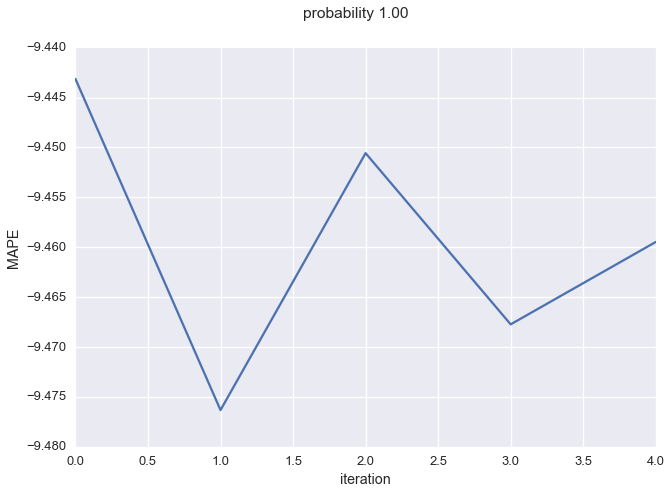

In [149]:
fig = plt.figure()
plt.plot(scores)
fig.suptitle("probability {:.2f}".format(sub_index / x_subtrain.shape[0]))
plt.xlabel('iteration')
plt.ylabel('MAPE')
plt.show()

0.5

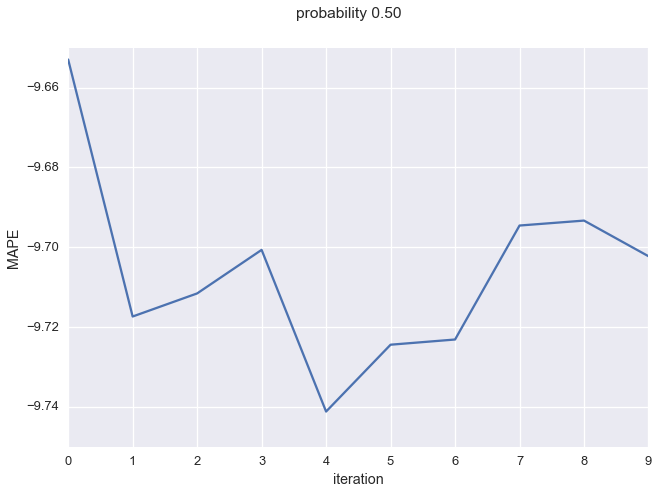

In [147]:
fig = plt.figure()
plt.plot(scores)
fig.suptitle("probability {:.2f}".format(sub_index / x_subtrain.shape[0]))
plt.xlabel('iteration')
plt.ylabel('MAPE')
plt.show()

0.9

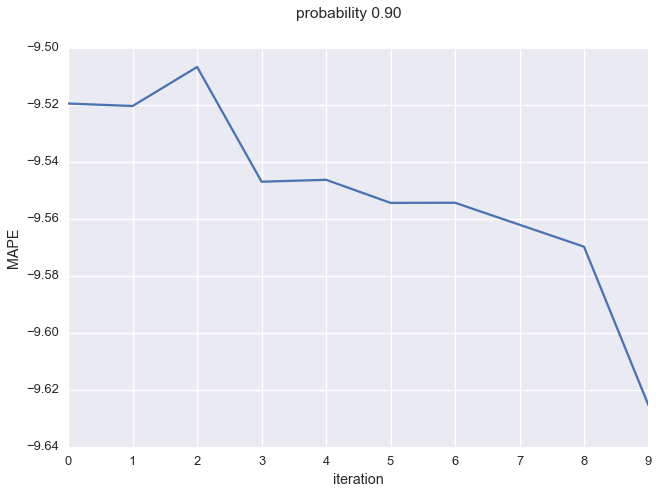

In [145]:
fig = plt.figure()
plt.plot(scores)
fig.suptitle("probability {:.2f}".format(sub_index / x_subtrain.shape[0]))
plt.xlabel('iteration')
plt.ylabel('MAPE')
plt.show()

Сделаем нормальный baseline. Обучим и diff, и inters на "нулевых" данных

In [137]:
inters_subtrain = y_subtrain - (slope + diff_subtrain) * np.array(subtrain.crm)

In [138]:
%%time
diff_est = ExtraTreesRegressor(n_estimators=10, max_features=51, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(X=x_subtrain, y=diff_subtrain)

CPU times: user 1min 13s, sys: 120 ms, total: 1min 13s
Wall time: 21.9 s


In [139]:
%%time
inters_est = ExtraTreesRegressor(n_estimators=10, max_features=51, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(X=x_subtrain, y=inters_subtrain)

CPU times: user 1min 15s, sys: 172 ms, total: 1min 15s
Wall time: 22.3 s


In [140]:
diff_pred = diff_est.predict(x_validation)
inters_pred = inters_est.predict(x_validation)
y_pred = restore_target(diff_pred, inters_pred, np.array(validation.crm), slope)
mape(y_validation, y_pred)

-9.6657743379075658

Посмотрим поближе n_est = 30

In [226]:
%%time
iteration = 0
sub_index = x_subtrain.shape[0]
diff_big_sub = diff_subtrain

x_sub, diff_sub = shuffle(x_subtrain, diff_big_sub, 
                          n_samples=sub_index, random_state=iteration * 4)
diff_est = ExtraTreesRegressor(
            n_estimators=30, max_features=51, 
            max_depth=None, n_jobs=-1, random_state=iteration * 4 + 1).fit(
                    X=x_sub, y=diff_sub)
diff_big_sub = diff_est.predict(x_subtrain)

inters_big_sub = y_subtrain - (slope + diff_big_sub) * np.array(subtrain.crm)
x_sub, inters_sub = shuffle(x_subtrain, inters_big_sub, 
                            n_samples=sub_index, random_state=iteration * 4 + 2)
inters_est = ExtraTreesRegressor(
              n_estimators=30, max_features=51, 
              max_depth=None, n_jobs=-1, random_state=iteration * 4 + 3).fit(
                      X=x_sub, y=inters_sub)
inters_big_sub = inters_est.predict(x_subtrain)
diff_big_sub = (y_subtrain - inters_big_sub) / np.array(subtrain.crm) - slope
gc.collect()

diff_pred = diff_est.predict(x_validation)
inters_pred = inters_est.predict(x_validation)
y_pred = restore_target(diff_pred, inters_pred, np.array(validation.crm), slope)

CPU times: user 8min 3s, sys: 1.33 s, total: 8min 4s
Wall time: 2min 9s


In [227]:
mape(y_validation, y_pred)

-9.3791445464105703

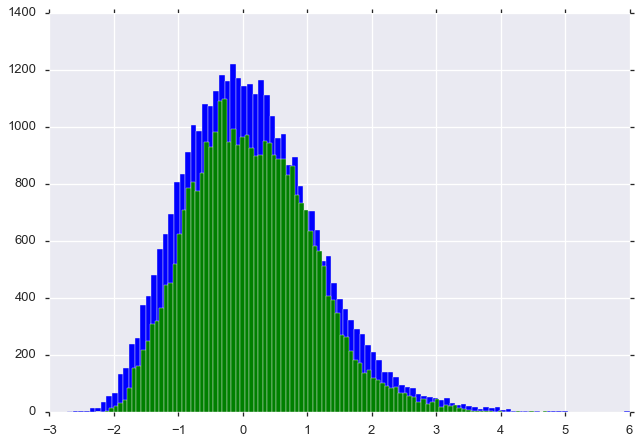

In [228]:
plt.hist(diff_validation, bins=100)
plt.hist(diff_pred, bins=100)
plt.show()

In [229]:
inters_validation = y_validation - (slope + diff_validation) * np.array(validation.crm)

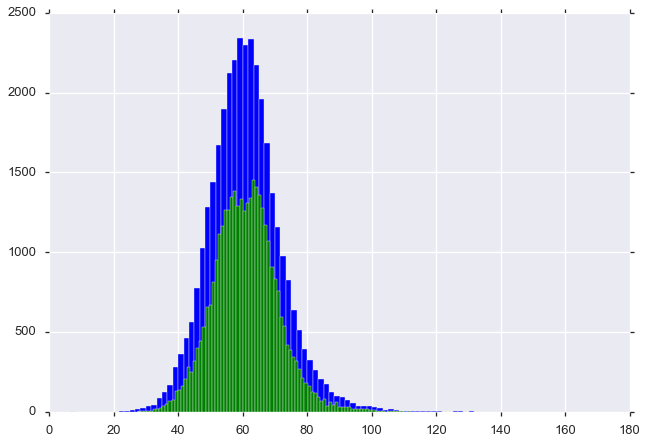

In [230]:
plt.hist(inters_validation, bins=100)
plt.hist(inters_pred, bins=100)
plt.show()

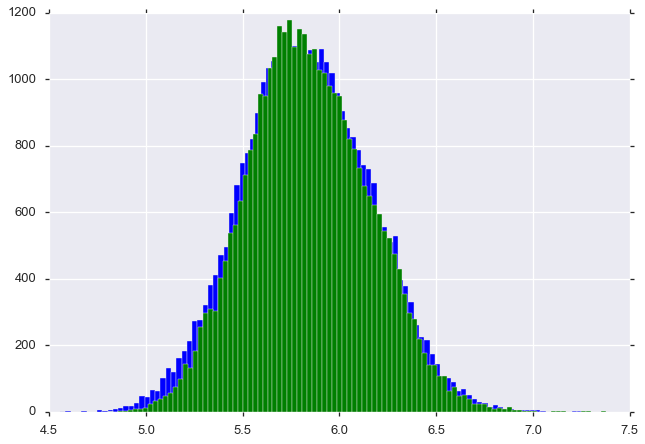

In [231]:
plt.hist(np.log(y_validation), bins=100)
plt.hist(np.log(y_pred), bins=100)
plt.show()

In [232]:
y_big_sub = restore_target(diff_big_sub, inters_big_sub, np.array(subtrain.crm), slope)
mape(y_subtrain, y_big_sub)

-1.7336875165578416e-15

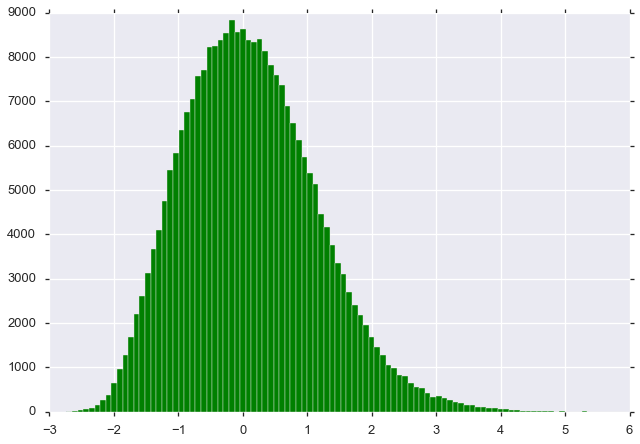

In [233]:
plt.hist(diff_subtrain, bins=100)
plt.hist(diff_big_sub, bins=100)
plt.show()

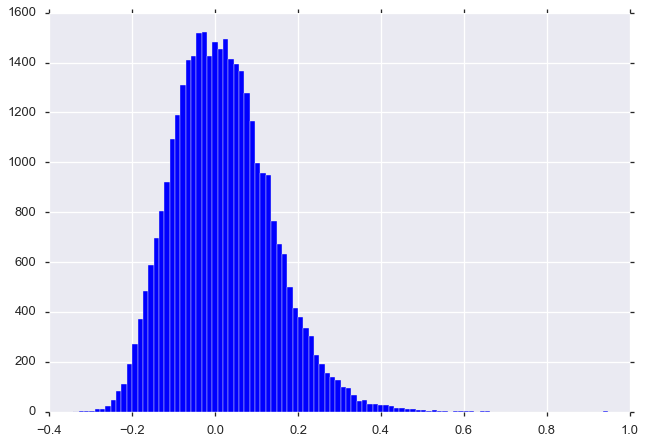

In [234]:
plt.hist((y_pred - y_validation) / y_validation, bins=100)
plt.show()

In [235]:
bad_val = validation.iloc[((y_pred - y_validation) / y_validation > 0.4)]

In [236]:
bad_val.shape

(146, 51)

In [237]:
bad_val.shape[0] / validation.shape[0]

0.004184700048725959

Надо поправить diff, увеличив дисперсию

In [256]:
diff_est = None
inters_est = None
gc.collect()

9

# Save

In [257]:
%%time
iteration = 0
sub_index = x_train.shape[0]
diff_big_sub = diff

x_sub, diff_sub = shuffle(x_train, diff_big_sub, 
                          n_samples=sub_index, random_state=iteration * 4)
diff_est = ExtraTreesRegressor(
            n_estimators=60, max_features=51, 
            max_depth=None, n_jobs=-1, random_state=iteration * 4 + 1).fit(
                    X=x_sub, y=diff_sub)
diff_big_sub = diff_est.predict(x_train)

inters_big_sub = y_train.flatten() - (slope + diff_big_sub) * np.array(train.crm)
x_sub, inters_sub = shuffle(x_train, inters_big_sub, 
                            n_samples=sub_index, random_state=iteration * 4 + 2)
inters_est = ExtraTreesRegressor(
              n_estimators=60, max_features=51, 
              max_depth=None, n_jobs=-1, random_state=iteration * 4 + 3).fit(
                      X=x_sub, y=inters_sub)
inters_big_sub = inters_est.predict(x_train)
diff_big_sub = (y_train.flatten() - inters_big_sub) / np.array(train.crm) - slope
gc.collect()

diff_pred = diff_est.predict(x_test)
inters_pred = inters_est.predict(x_test)
y_pred = restore_target(diff_pred, inters_pred, np.array(test.crm), slope)

CPU times: user 19min 3s, sys: 10.7 s, total: 19min 14s
Wall time: 5min 21s


In [258]:
save_to_file(y_pred, 'xtr.csv')